NOTE: For other methods, replace all terms with "emmvi" for the acronym of new method.
      Check it in all cells of this notebook and just replace it and the method itself!

### LIBRARIES

In [1]:
#LIBRARIES TO BE USED

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from datetime import datetime
import os

#VARIABLES USED IN DIFFERENT STEPS OF PROCESS
results_folder = "../_results" #Folder where results and charts will be exported
os.makedirs(results_folder, exist_ok=True) #Create result folder if does not exist
current_datetime = datetime.now().strftime("%Y%m%d%H%M%S") #Get the current date and time

### IMPORT DATASET WITH MISSING VALUES AND THE ORIGINAL

In [107]:
#IMPORT DATASET WITH MISSING VALUES
df_90 = pd.read_csv('../_datasets/google_trend_pinhao_90percent.csv')
df_90["Mes"] = pd.to_datetime(df_90["Mes"], format="%Y-%m", errors='coerce') #Change from string to date format
df_90["Pinhao: (Parana)"] = pd.to_numeric(df_90["Pinhao: (Parana)"], errors='coerce').astype("Int64") #Change from object to int64

df_80 = pd.read_csv('../_datasets/google_trend_pinhao_80percent.csv')
df_80["Mes"] = pd.to_datetime(df_80["Mes"], format="%Y-%m", errors='coerce') #Change from string to date format
df_80["Pinhao: (Parana)"] = pd.to_numeric(df_80["Pinhao: (Parana)"], errors='coerce').astype("Int64") #Change from object to int64

#IMPORT ORIGINAL DATASET (WITH ALL VALUES)
df_original = pd.read_csv('../_datasets/google_trend_pinhao_original.csv', skiprows=1, header=None, names=["Mes", "Pinhao: (Parana)"])
df_original["Pinhao: (Parana)"] = pd.to_numeric(df_original["Pinhao: (Parana)"], errors='coerce').astype("Int64") #Change from object to int64
df_original["Mes"] = pd.to_datetime(df_original["Mes"], format="%Y-%m", errors='coerce') #Change from string to date format
df_original = df_original.drop(0) #delete line zero due it is not relevant
df_original = df_original.reset_index(drop=True) #reset the index starting from 0

### APPLICATION OF THE METHOD
##### [!] ATTENTION: For google trends dataframe, imputed values must be int64


In [108]:
# Linear Regression model
def llrvi(df):
    numericos=df[df['Pinhao: (Parana)'].notna()]['Pinhao: (Parana)']
    faltantes=df[df['Pinhao: (Parana)'].isna()]['Pinhao: (Parana)']
    
    # Predictions list
    cont=0
    list_pred=[]
    for order, value in enumerate(faltantes.index):       
        
        # Training is done with all instances until penultimate before the missing instance
        X_train=np.array(numericos.shift(1)[1:value-1-cont]).reshape(-1,1)
        y_train=np.array(numericos[1:value-1-cont]).reshape(-1,1)
        model = LinearRegression()
        model.fit(X_train, y_train)
        cont+=1
        
        # Prediction is done with the instance before missing instance
        y_pred=model.predict(np.array(numericos.shift(1).loc[value-1]).reshape(-1,1))
        list_pred.append(y_pred[0][0])

    # Concat (originals + predictions)
    list_final=[]
    cont=0
    for order, value in enumerate(df['Pinhao: (Parana)']):
          if str(value).isnumeric():
                list_final.append(value)
          else:
                list_final.append(list_pred[cont])
                cont+=1
    df['Pinhao: (Parana)']=list_final
    return df 


df_pred=llrvi(df_80.copy())
df_pred

,Mes,Pinhao: (Parana)
0,2004-01-01,59.000000
1,2004-02-01,0.000000
2,2004-03-01,0.000000
3,2004-04-01,0.000000
4,2004-05-01,42.000000
...,...,...
228,2023-01-01,28.839993
229,2023-02-01,29.000000
230,2023-03-01,28.000000
231,2023-04-01,42.000000


In [109]:
#JUST TO CHECK IF ALL DATAFRAMES HAVE THE SAME SHAPE AND DTYPE
df_original.info()
df_80.info()
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Mes               233 non-null    datetime64[ns]
 1   Pinhao: (Parana)  233 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 4.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Mes               233 non-null    datetime64[ns]
 1   Pinhao: (Parana)  187 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 4.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Mes               233 non-nul

### PERFORMANCE INDEXES/METRICS

In [110]:
#Error indexes
mae = mean_absolute_error(df_original["Pinhao: (Parana)"], df_pred["Pinhao: (Parana)"])
mse = mean_squared_error(df_original["Pinhao: (Parana)"], df_pred["Pinhao: (Parana)"])
r2 = r2_score(df_original["Pinhao: (Parana)"], df_pred["Pinhao: (Parana)"])

#Accuracry index (How many imputation data are right)
threshold = 0.1  #Maximum deviation accepted to be considered right (more than this will be considered erro)
accuracy = np.mean(np.abs(df_pred["Pinhao: (Parana)"] - df_original["Pinhao: (Parana)"]) <= threshold)

#Acceptance range for the indexes/metrics
mae_good_range = np.std(df_original["Pinhao: (Parana)"], ddof=1) #Standard deviation 
mse_good_range = (np.std(df_original["Pinhao: (Parana)"], ddof=1)**2) #Squared standard deviation 
r2_good_range = (0.80, 1)
accuracy_good_range = (0.9, 1)  

#Compare indexes results with range and define if they are good or bad
mae_status = "Good performance!" if (mae_good_range*-1) <= mae <= mae_good_range else "[!] BAD PERFORMANCE"
mse_status = "Good performance!" if (mse_good_range*-1) <= mse <= mse_good_range else "[!] BAD PERFORMANCE"
r2_status = "Good performance!" if r2_good_range[0] <= r2 <= r2_good_range[1] else "[!] BAD PERFORMANCE"
accuracy_status = "Good performance!" if accuracy_good_range[0] <= accuracy <= accuracy_good_range[1] else "[!] BAD PERFORMANCE"

#Print values
print(f'Mean Absolute Error (MAE): {mae} {mae_status}')
print(f'Mean Squared Error (MSE): {mse} {mse_status}')
print(f'R-squared Score (R²): {r2} {r2_status}')
print(f'Accuracy: {mae} {accuracy_status}')

Mean Absolute Error (MAE): 2.774793732699877 Good performance!
Mean Squared Error (MSE): 86.22921776431747 Good performance!
R-squared Score (R²): 0.7525407230823613 [!] BAD PERFORMANCE
Accuracy: 2.774793732699877 [!] BAD PERFORMANCE


c:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
c:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
c:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.

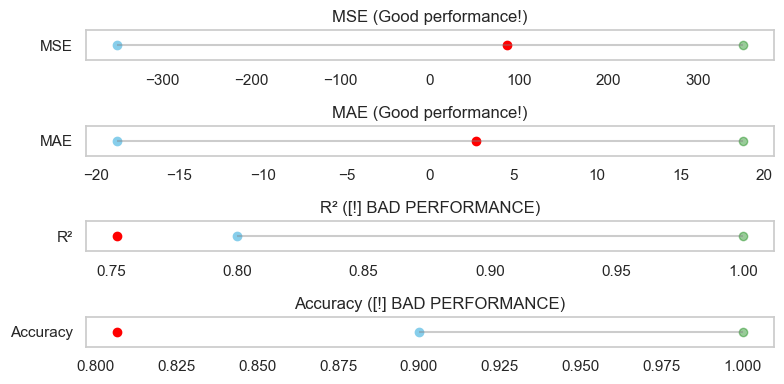

In [111]:
#CHART OF ACCEPTANCE RANGE AND INDEXES VALUES

#Create a new dataframe specific for this plot
indexes_plot = pd.DataFrame({'group': ['R²', 'MAE', 'MSE', 'Accuracy'],
                   'min': [r2_good_range[0], (mae_good_range * -1), (mse_good_range * -1), accuracy_good_range[0]],
                   'max': [r2_good_range[1], mae_good_range, mse_good_range, accuracy_good_range[1]],
                   'value': [r2, mae, mse, accuracy],
                   'status': [r2_status, mae_status, mse_status, accuracy_status]})
ordered_indexes_plot = indexes_plot.sort_values(by='min') #put the dataframe in order to plot

#Subplot1 config
indexes_plot_filename = f"{results_folder}/df_pred_chart1_indexes_plot_{current_datetime}.jpg"
fig, axs = plt.subplots(4, 1, figsize=(8, 4))

#Charts of subplot1
for i, ax in enumerate(axs):
    ax.hlines(y=1, xmin=ordered_indexes_plot['min'].iloc[i], xmax=ordered_indexes_plot['max'].iloc[i], color='grey', alpha=0.4)
    ax.scatter(ordered_indexes_plot['min'].iloc[i], 1, color='skyblue', alpha=1, label='Min')
    ax.scatter(ordered_indexes_plot['max'].iloc[i], 1, color='green', alpha=0.4, label='Max')
    ax.scatter(ordered_indexes_plot['value'].iloc[i], 1, color='red', alpha=1, label='Index Value')
    ax.set_yticks([1])
    ax.set_yticklabels([ordered_indexes_plot['group'].iloc[i]])
    title = "{} ({})".format(ordered_indexes_plot['group'].iloc[i], ordered_indexes_plot['status'].iloc[i])
    ax.set_title(title)
    ax.grid(False)


plt.tight_layout()
plt.show()




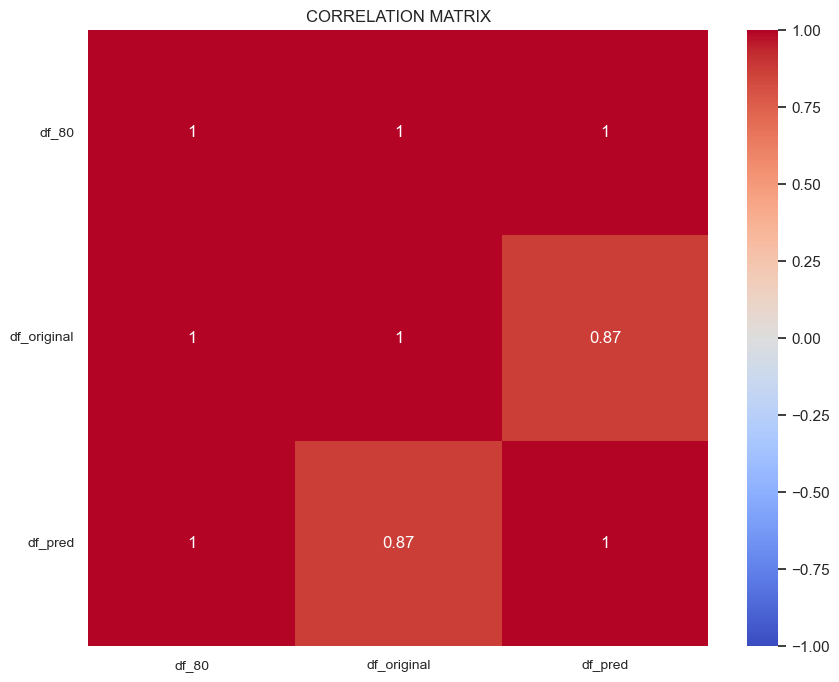

In [112]:
# Correlation between original dataframe, dataframe with missing data, and dataframe with imputed values
df_pred_selected = df_pred["Pinhao: (Parana)"]  # Dataframe with imputed values
df_80_selected = df_80["Pinhao: (Parana)"]  # Dataframe with missing values
df_original_selected = df_original["Pinhao: (Parana)"]  # Original dataframe

# Correlation between them
dfs_merged = pd.concat([df_80["Mes"], df_80["Pinhao: (Parana)"], df_original["Pinhao: (Parana)"], df_pred["Pinhao: (Parana)"]], axis=1)
dfs_merged.set_index("Mes", inplace=True)
dfs_merged.columns = ["df_80", "df_original", "df_pred"]
correlation_matrix = dfs_merged.corr()

# Extract correlation values
correlation_original_90 = correlation_matrix.loc["df_original", "df_80"]
correlation_original_imputed = correlation_matrix.loc["df_original", "df_pred"]
correlation_90_imputed = correlation_matrix.loc['df_80', 'df_pred']

# Chart plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.tick_params(axis='both', which='both', length=0, labelrotation=0, labelsize=10, pad=10)
plt.title(f'CORRELATION MATRIX')
plt.show()


In [113]:
#JUST TO SHOW THE DIFFERENT VALUES BETWEEN ORIGINAL DATAFRAME, MISSING VALUES DATAFRAME AND IMPUTED DATAFRAME
dfs_merged_filtered = dfs_merged[dfs_merged.nunique(axis=1) > 1]
dfs_merged_filtered

,df_80,df_original,df_pred
Mes,,,
2005-01-01,<NA>,0,5.214088
2005-05-01,<NA>,0,11.645481
2005-07-01,<NA>,20,12.383924
2005-11-01,<NA>,21,10.056202
2006-05-01,<NA>,34,14.481045
2006-07-01,<NA>,11,17.870138
2007-01-01,<NA>,11,13.428571
2007-05-01,<NA>,41,12.771373
2007-07-01,<NA>,21,14.542934


## CHARTS

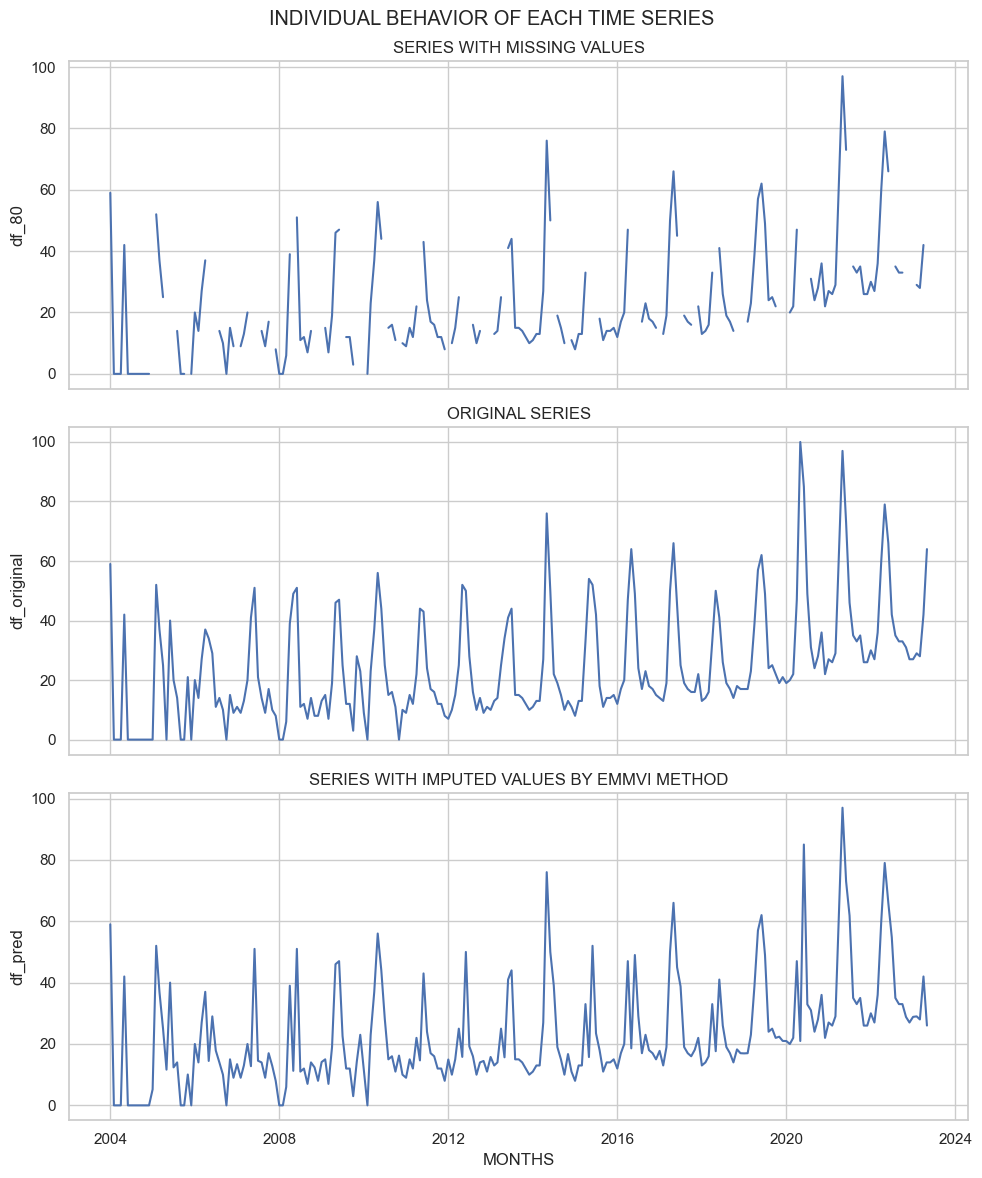

In [114]:
#LINEPLOT OF ALL DATAFRAMES

numeric_columns = ["df_80", "df_original", "df_pred"]
dfs_merged[numeric_columns] = dfs_merged[numeric_columns].astype(float)

#Subplot config
lineplot_all_dataframes = f"{results_folder}/df_pred_chart2_lineplot_all_dataframes_{current_datetime}.jpg"
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

#Lineplot 1
axs[0].plot(dfs_merged.index, dfs_merged["df_80"])
axs[0].set_ylabel("df_80")
axs[0].set_title("SERIES WITH MISSING VALUES")

#Lineplot 2
axs[1].plot(dfs_merged.index, dfs_merged["df_original"])
axs[1].set_ylabel("df_original")
axs[1].set_title("ORIGINAL SERIES")

#Lineplot 3
axs[2].plot(dfs_merged.index, dfs_merged["df_pred"])
axs[2].set_ylabel("df_pred")
axs[2].set_title("SERIES WITH IMPUTED VALUES BY EMMVI METHOD")

# Label Config
axs[-1].set_xlabel("MONTHS")

# Title Config
plt.suptitle("INDIVIDUAL BEHAVIOR OF EACH TIME SERIES")

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

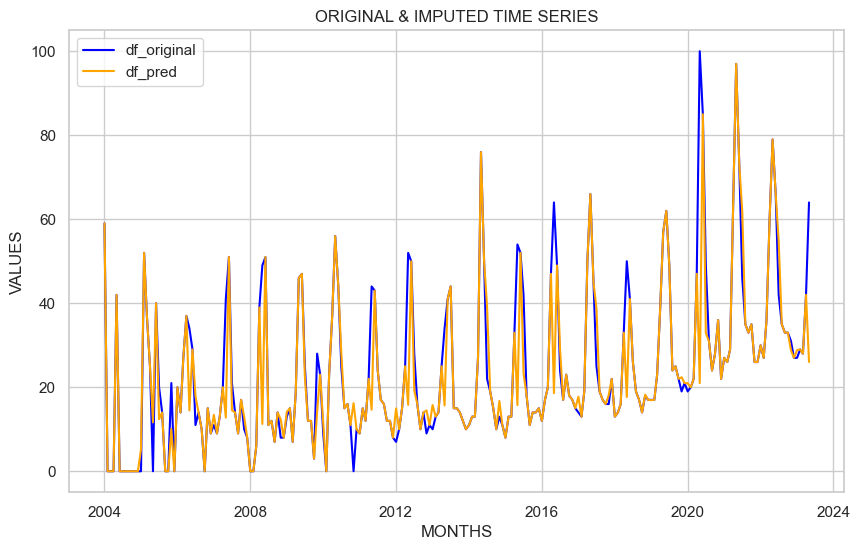

In [115]:
#LINEPLOT OF ORIGINAL DATASET AND IMPUTED DATASET OVERLAPPED
lineplot_overlapped_series = f"{results_folder}/df_80_emmvi_chart3_lineplot_overlapped_series_{current_datetime}.jpg"
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))

plt.plot(dfs_merged.index, dfs_merged["df_original"], color="blue", label="df_original")
plt.plot(dfs_merged.index, dfs_merged["df_pred"], color="orange", label="df_pred")

plt.xlabel("MONTHS")
plt.ylabel("VALUES")
plt.title("ORIGINAL & IMPUTED TIME SERIES")
plt.legend()

plt.show()

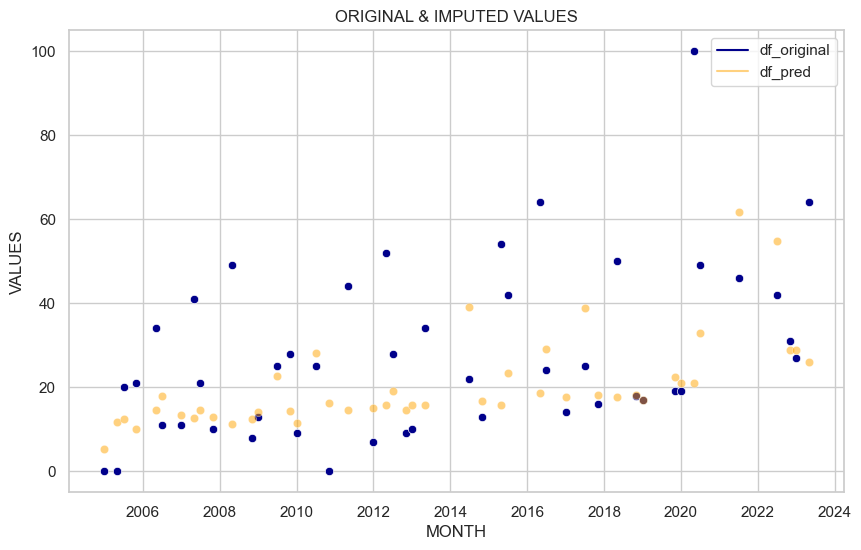

In [116]:
#SCATTERPLOT COMPARING THE ORIGINAL DATAS WITH THE IMPUTED ONES

scatterplot_original_imputed = f"{results_folder}/df_80_emmvi_chart4_scatterplot_original_imputed_{current_datetime}.jpg"
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dfs_merged_filtered, x=dfs_merged_filtered.index, y="df_original", color="darkblue", label="df_original")
sns.scatterplot(data=dfs_merged_filtered, x=dfs_merged_filtered.index, y="df_pred", color="orange", alpha=0.5, label="df_pred")

plt.xlabel("MONTH")
plt.ylabel("VALUES")
plt.title("ORIGINAL & IMPUTED VALUES")

blue_patch = plt.Line2D([], [], color='darkblue', label='df_original')
orange_patch = plt.Line2D([], [], color='orange', alpha=0.5, label='df_pred')
plt.legend(handles=[blue_patch, orange_patch])

plt.show()


In [84]:
from pathlib import Path
import openpyxl

#Ask user if they want to export the data
user_input = input("[!] Do you want to export the results to the log file? (yes/no): ")

if user_input.lower() == "yes":
    
    #Path where log must be recorded, readed or modified
    results_path = "../_results/results.xlsx"
    results_path = Path(results_path)
    #Create the dataframe with the results values
    results_df = pd.DataFrame({
        "date_and_time": [datetime.now()],
        "dataframe_and_method": ["df_80_emmvi"],
        "result_mae": [mae],
        "result_mse": [mse],
        "result_r2": [r2],
        "result_accuracy": [accuracy],
        "status_mae": [mae_status],
        "status_mse": [mse_status],
        "status_r2": [r2_status],
        "status_accurancy": [accuracy_status],
        "min_range_mae": [mae_good_range*-1],
        "min_range_mse": [mse_good_range*-1],
        "min_range_r2": [r2_good_range[0]],
        "min_range_accuracy": [accuracy_good_range[0]],
        "max_range_mae": [mae_good_range],
        "max_range_mse": [mse_good_range],
        "max_range_r2": [r2_good_range[1]],
        "max_range_accuracy": [accuracy_good_range[1]],
        "correlation_original_90": [correlation_original_90],
        "correlation_original_imputed": [correlation_original_imputed],
        "correlation_90_imputed": [correlation_90_imputed]
    })

    #Check if the file exists
    if results_path.exists(): #Load log file that exists
        workbook = openpyxl.load_workbook(results_path) #Open log file (excel file in this case)
        worksheet = workbook["Results"] #Find the worksheet where results will be recorded
        last_row = worksheet.max_row #Find the last row in the worksheet to record the results
        for index, value in enumerate(results_df.columns, start=1): #Add the new row to the worksheet
            worksheet.cell(row=last_row+1, column=index, value=results_df[value][0])
        workbook.save(results_path) #Save the workbook
    else: #Create a new log file (in excel) in case it do not exist yet.
        results_df.to_excel(results_path, index=False, sheet_name='Results')

    #Export charts
    plt.savefig(indexes_plot_filename)
    plt.savefig(lineplot_all_dataframes)
    plt.savefig(lineplot_overlapped_series)
    plt.savefig(scatterplot_original_imputed)
    plt.close()
else:
    print("Data export canceled by user. Exiting the code...")
